In [3]:
pip install dpkt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.0/195.0 kB 19.9 MB/s eta 0:00:00


Dataframe with the size and duration of each flow, with other information:                                                                         Size  \
Source IP       Destination IP Source Port Source Destination Protocol         
100.176.176.244 41.177.26.176  49807       80                 TCP       1376   
100.176.176.56  41.177.26.91   49018       80                 TCP        981   
105.241.75.197  244.3.31.40    3150        445                TCP         96   
106.188.67.194  244.3.31.244   1734        445                TCP         96   
106.204.142.139 244.3.31.41    1789        445                TCP         96   
...                                                                      ...   
94.2.202.203    244.3.160.239  80          46009              TCP        427   
94.2.202.98     244.3.160.239  80          44723              TCP        927   
                                           45341              TCP        879   
                                           45

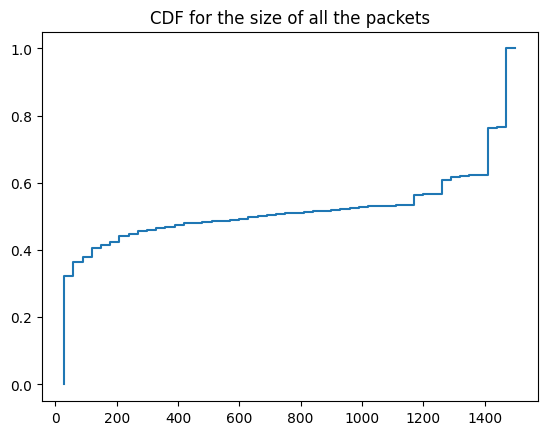

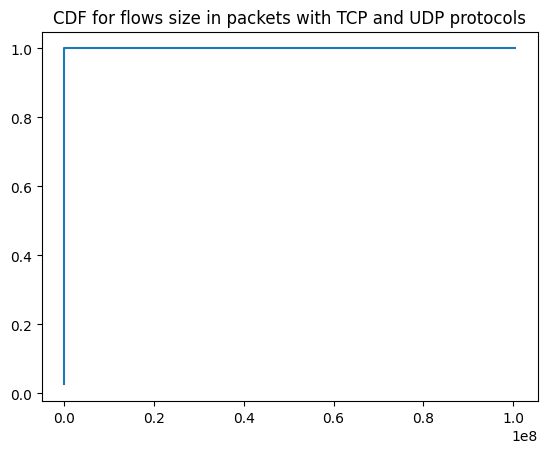

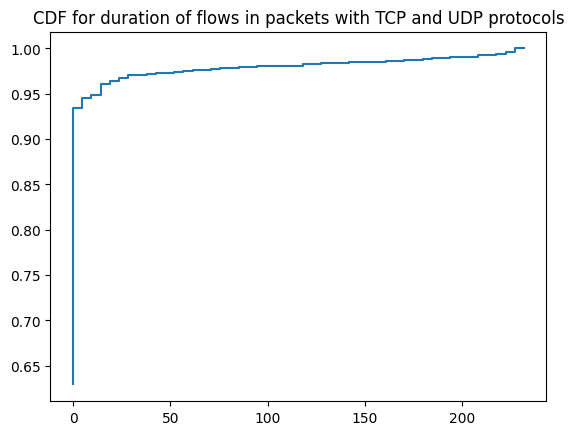

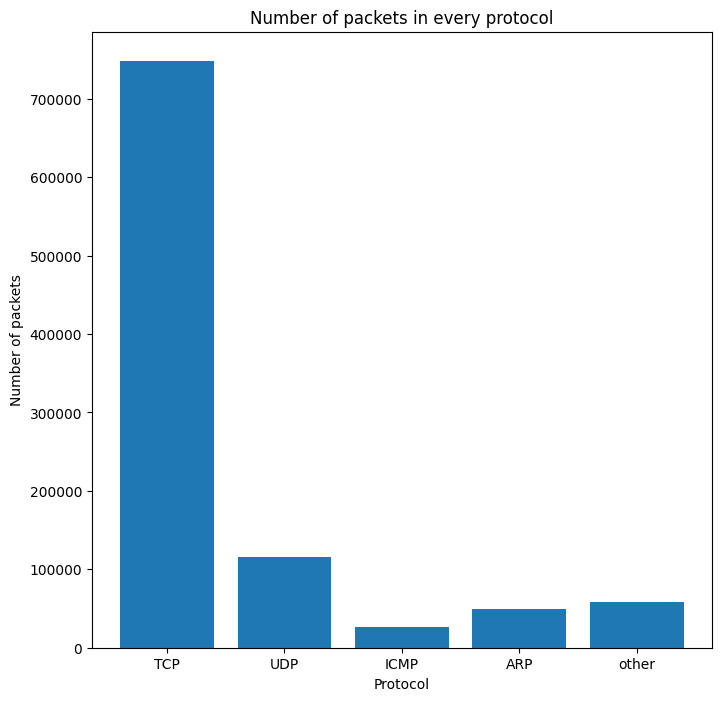

In [9]:
# Import the necessary libraries
import dpkt
import socket
import pandas as pd
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt

# The following function converts an inet object into a string
def inet_to_str(inet):
    # First try ipv4 and then ipv6
    try:
        return socket.inet_ntop(socket.AF_INET, inet)
    except ValueError:
        return socket.inet_ntop(socket.AF_INET6, inet)
 
        
def main():

    # First we parse the trace.pcap file
    with open('trace.pcap', 'rb') as f:
        pcap = dpkt.pcap.Reader(f)
        
        # We initiallize some variables and lists
        tcp_packages = 0
        udp_packages = 0
        icmp_packages = 0
        arp_packages = 0
        other_packages = 0
        all_packages = 0
        ip_source_list = []
        ip_destination_list = []
        port_source_list = []
        port_destination_list =[]
        protocol_list = []
        size_list = []
        timestamp_list = []
        
        # We start a for loop to iterate in each packet and extract information
        for timestamp, buf in pcap:
    
            # Unpack the Ethernet and the IP packet
            eth = dpkt.ethernet.Ethernet(buf)
            ip = eth.data
    
            # Extract the ARP packages
            if not isinstance(eth.data, dpkt.ip.IP):
                if hasattr(eth, "arp"):
                   arp_packages = arp_packages + 1 
                all_packages = all_packages + 1   
                continue 
            
            # Determine the protocol and then the packet size
            protocol = ""
            if ip.p == dpkt.ip.IP_PROTO_TCP:
                protocol = "TCP"
            elif ip.p == dpkt.ip.IP_PROTO_UDP:
                protocol = "UDP"
            elif ip.p == dpkt.ip.IP_PROTO_ICMP:
                protocol = "ICMP"
            elif eth.type == dpkt.ethernet.ETH_TYPE_ARP:
              protocol = "ARP"
            else:
              protocol = "Other"
            packet_size = ip.len
            
            # As we determined the protocols, we extract the number of the packages of each protocol
            # Especially for TCP and UDP protocols we extract some more info in lists
            if protocol == 'TCP': 
               ip_source_list.append(inet_to_str(ip.src))
               ip_destination_list.append(inet_to_str(ip.dst))
               port_source_list.append(ip.data.sport)
               port_destination_list.append(ip.data.dport)
               protocol_list.append(protocol)
               size_list.append(packet_size)
               timestamp_list.append(timestamp)
               tcp_packages = tcp_packages + 1
               
            elif protocol == 'UDP':
               ip_source_list.append(inet_to_str(ip.src))
               ip_destination_list.append(inet_to_str(ip.dst))
               port_source_list.append(ip.data.sport)
               port_destination_list.append(ip.data.dport)
               protocol_list.append(protocol)
               size_list.append(packet_size)
               timestamp_list.append(timestamp)
               udp_packages = udp_packages + 1 
               
            elif protocol == 'ICMP':
               icmp_packages = icmp_packages + 1   
                   
            all_packages = all_packages + 1
            
        # We create a dataframe with all the info from the lists we created 
        # In this dataframe, there are the characteristics of packets with TCP and UDP protocols.
        # After that, we can create the dataframe that was asked with the size and the 
        # duration of each flow  
        characteristics = list(zip(ip_source_list, ip_destination_list, port_source_list, 
                               port_destination_list, protocol_list, size_list, timestamp_list))
        characteristics_df = pd.DataFrame(characteristics, 
                                      columns = ['Source IP', 'Destination IP', 'Source Port', 
                                                 'Source Destination', 'Protocol', 'Size', 'Timestamp'])
        flows_df = characteristics_df.groupby(['Source IP', 'Destination IP', 'Source Port', 
                                          'Source Destination', 'Protocol']).agg({'Size':'sum','Timestamp': lambda x: x.max() - x.min()})
        flows_df = flows_df.rename(columns={'Timestamp': 'Duration'})
        
        # Print this dataframe with all it's information
        print("Dataframe with the size and duration of each flow, with other information:",flows_df)

        # As we have the number of all types of packages, we calculate the number 
        # of packages with other protocols that not mentioned
        other_packages = all_packages - (tcp_packages + udp_packages + icmp_packages + arp_packages) 
        
        # Print the total number and percentage of packets in each protocol
        print("We have total ",all_packages," packages")
        print("The number of TCP protocol packages is: ",tcp_packages, " with percentage: ",(tcp_packages/all_packages)*100,"%")
        print("The number of UDP protocol packages is: ",udp_packages, " with percentage: ",(udp_packages/all_packages)*100,"%")
        print("The number of ICMP protocol packages is: ",icmp_packages, " with percentage: ",(icmp_packages/all_packages)*100,"%")
        print("The number of ARP protocol packages is: ",arp_packages, " with percentage: ",(arp_packages/all_packages)*100,"%")
        print("The number of Other protocol packages is: ",other_packages," with percentage: ",
         (other_packages/all_packages)*100,"%")
               
        # Now we are ready to make some useful plots
        # Firstly, we plot the CDF for the size of all the packets
        sample = np.sort(list(characteristics_df['Size'].values))
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample))
        y = ecdf(x)
        plt.step(x, y)
        plt.title("CDF for the size of all the packets")
        plt.show()
        # Secondly, we plot the CDF for flows size in packets with TCP and UDP protocols
        sample = np.sort(list(flows_df['Size'].values))
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample))
        y = ecdf(x)
        plt.step(x, y)
        plt.title("CDF for flows size in packets with TCP and UDP protocols")
        plt.show()
        # Then, we plot the CDF for duration of flows in packets with TCP and UDP protocols
        sample = np.sort(list(flows_df['Duration'].values))
        ecdf = sm.distributions.ECDF(sample)
        x = np.linspace(min(sample), max(sample))
        y = ecdf(x)
        plt.step(x, y)
        plt.title("CDF for duration of flows in packets with TCP and UDP protocols")
        plt.show()
        # Finally, we make a barplot showing the total number of packets in each protocol
        protocols = ('TCP', 'UDP', 'ICMP', 'ARP', 'other')
        values = (tcp_packages, udp_packages, icmp_packages, arp_packages, other_packages)
        plt.figure(figsize=(8,8))
        plt.bar(protocols, values)
        plt.xlabel("Protocol")
        plt.ylabel("Number of packets")
        plt.title('Number of packets in every protocol')
        plt.show()
   
if __name__ == '__main__':
    main()